In [8]:
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Load dataset
with open("train_val_test.pkl", "rb") as f:
    X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(f)

print("Data successfully loaded!")


Data successfully loaded!


In [9]:
# Convert categorical features to category dtype for XGBoost
categorical_features = ["sub_grade", "purpose"]
for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_val[col] = X_val[col].astype("category")
    X_test[col] = X_test[col].astype("category")

print("Categorical processing complete.")


Categorical processing complete.


In [10]:
import xgboost as xgb

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  # Multi-class classification
    num_class=len(y_train.unique()),  # Number of unique classes
    tree_method="hist",  # Faster training
    enable_categorical=True,  # Use categorical support
    use_label_encoder=False,
    eval_metric="mlogloss"  # Move eval_metric here
)

# Train the model with early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Validation set
    
)

print("Model training complete.")


[0]	validation_0-mlogloss:0.53990
[1]	validation_0-mlogloss:0.45770
[2]	validation_0-mlogloss:0.40920
[3]	validation_0-mlogloss:0.37998
[4]	validation_0-mlogloss:0.36153
[5]	validation_0-mlogloss:0.34989
[6]	validation_0-mlogloss:0.34248
[7]	validation_0-mlogloss:0.33798
[8]	validation_0-mlogloss:0.33512
[9]	validation_0-mlogloss:0.33340


/Users/jiaxuanliu/anaconda3/envs/math170/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:15:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-mlogloss:0.33216
[11]	validation_0-mlogloss:0.33152
[12]	validation_0-mlogloss:0.33100
[13]	validation_0-mlogloss:0.33069
[14]	validation_0-mlogloss:0.33069
[15]	validation_0-mlogloss:0.33052
[16]	validation_0-mlogloss:0.33053
[17]	validation_0-mlogloss:0.33046
[18]	validation_0-mlogloss:0.33053
[19]	validation_0-mlogloss:0.33082
[20]	validation_0-mlogloss:0.33056
[21]	validation_0-mlogloss:0.33075
[22]	validation_0-mlogloss:0.33090
[23]	validation_0-mlogloss:0.33107
[24]	validation_0-mlogloss:0.33146
[25]	validation_0-mlogloss:0.33164
[26]	validation_0-mlogloss:0.33199
[27]	validation_0-mlogloss:0.33224
[28]	validation_0-mlogloss:0.33230
[29]	validation_0-mlogloss:0.33248
[30]	validation_0-mlogloss:0.33268
[31]	validation_0-mlogloss:0.33264
[32]	validation_0-mlogloss:0.33281
[33]	validation_0-mlogloss:0.33290
[34]	validation_0-mlogloss:0.33335
[35]	validation_0-mlogloss:0.33375
[36]	validation_0-mlogloss:0.33382
[37]	validation_0-mlogloss:0.33408
[38]	validation_0-ml

In [11]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8699


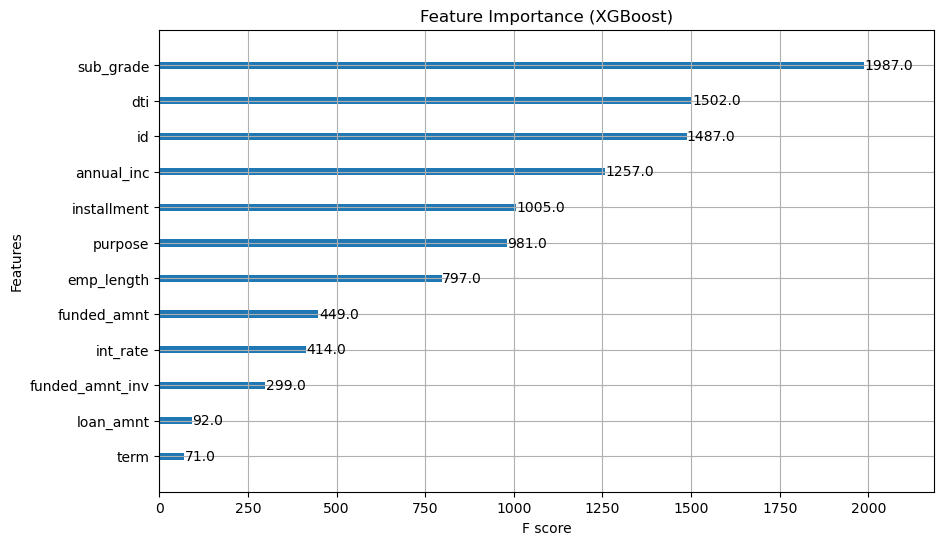

In [12]:
# Feature Importance
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type="weight", ax=ax)
plt.title("Feature Importance (XGBoost)")
plt.show()

In [15]:
# Get feature importance scores
feature_importance = xgb_model.get_booster().get_score(importance_type="weight")

# Convert to DataFrame for better readability
importance_df = pd.DataFrame(
    feature_importance.items(),
    columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

importance_df

,Feature,Importance
7,sub_grade,1987.0
10,dti,1502.0
0,id,1487.0
9,annual_inc,1257.0
6,installment,1005.0
11,purpose,981.0
8,emp_length,797.0
1,funded_amnt,449.0
5,int_rate,414.0
3,funded_amnt_inv,299.0
